# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a camera above a highway. Here the most difficult task is to predict 3 dimensions of each vehicle while we only have a single image (2D). We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get width, height and length of the vehicle. We assume that cars are all driving the same direction with straight trajectory. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.optim as optim

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 1280
input_height = 720

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 32

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 2

# Load dataset

In [4]:
from utils import make_euler, Box, get_position_ground

to_world_from_camera = np.identity(4)
pitch_matrix = make_euler(-27.4 * np.pi / 180, 0)
to_world_from_camera[:3, :3] = pitch_matrix
to_world_from_camera[:3, 3] = np.array([0, 8.5, 0])

f = 770.19284237
K = np.array(
    [[f, 0.0, 640.0], [0.0, f, 360.0], [0.0, 0.0, 1.0]]
)

h_fov = 2 * np.arctan(1280 / (2 * f)) * 180 / np.pi
v_fov = 2 * np.arctan(720 / (2 * f)) * 180 / np.pi
print(f"Horizontal fov = {h_fov:.2f} deg. Vertical fov = {v_fov:.2f} deg")


Horizontal fov = 79.45 deg. Vertical fov = 50.10 deg


Image image_1175.png
Image shape = (720, 1280, 3)


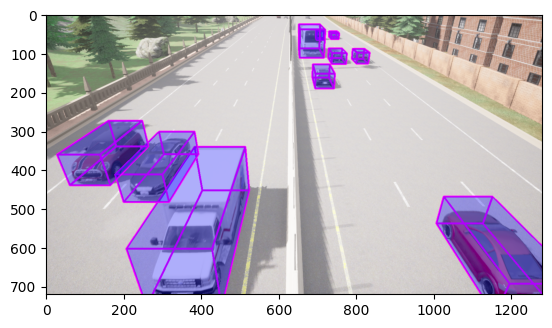

In [5]:
dataset_folder = 'carla_dataset/images/'

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder))
#IMAGE = "image_0050.png"

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder, IMAGE))
img = cv2.resize(img, (1280, 720))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


print(f"Image shape = {img.shape}")

labels = pd.read_csv(f"carla_dataset/labels/{IMAGE[:-4]}.txt").to_numpy()
# print(labels)

for label in labels:
    position_on_ground = get_position_ground(
        label[0], label[1], K, to_world_from_camera, img.shape[0]
    )

    box = Box(
        position_on_ground[0],
        position_on_ground[2],
        label[2],
        label[3],
        label[4],
    )
    # print(label)
    img = box.project(img, to_world_from_camera, K)

#plt.figure(figsize=(14,14))
plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [6]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    #??
    #assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [21]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
def make_hm_offset_regr(target):
    hm = np.zeros([input_height//MODEL_SCALE+1, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE+1, input_width//MODEL_SCALE])
    regr = np.zeros([3, input_height//MODEL_SCALE+1, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset, regr
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        hm = draw_msra_gaussian(hm, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=1)
        # WTF??
        if not (0 <= c["x"] < input_width and 150 <= c["y"] < input_height): # MODIFIED!!
            continue
            
        assert 0 <= c["x"] < input_width
        assert 0 <= c["y"] < input_height
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
        position_on_ground = get_position_ground(
            c["x"], c["y"], K, to_world_from_camera, 720
        )
        
        depth = np.linalg.norm(position_on_ground - to_world_from_camera[:3, 3])
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/depth
                    regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["h"]/depth
                    regr[2, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["l"]/depth
                except:
                    pass
        
    return hm, offset, regr


In [22]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [23]:
def pred2box(hm, offset, regr, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0], b[1], b[2]])
        boxes.append(arr)
    return np.asarray(boxes), scores

In [24]:
# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        position_on_ground = get_position_ground(
            box[0], box[1], K, to_world_from_camera, img.shape[0]
        )
        
        depth = np.linalg.norm(position_on_ground - to_world_from_camera[:3, 3])
        
        #print(box)
        #print(depth)

        box = Box(
            position_on_ground[0],
            position_on_ground[2],
            box[2]*depth,
            box[3]*depth,
            box[4]*depth,
        )
        
        
        # print(label)
        sample = box.project(sample, to_world_from_camera, K)
        
    return sample


# Make Pytorch dataset with dataloader

In [25]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder)), test_size=0.2, random_state=777, shuffle=False)

In [26]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image

import random

class CarlaDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, train = False):
        self.img_id = img_id
        self.train = train
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        #print(f"Call {self.img_id[idx]}")
        img = cv2.imread(os.path.join(dataset_folder, self.img_id[idx]))
        img = cv2.resize(img, (input_width, input_height))
        
        if self.train:
            # Lets do a bit of data augmentation with RGB to BGR, and color jittering
            if np.random.rand() > 0.5:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            rgb_offset = np.random.randint(-20, 20, size=3).astype('uint8')
            img += rgb_offset
            
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        
        labels = pd.read_csv(f"carla_dataset/labels/{self.img_id[idx][:-4]}.txt")
        hm, offset, regr = make_hm_offset_regr(labels)

        return img, hm, offset, regr


In [27]:
traindataset = CarlaDataset(train_id, train = True)
valdataset = CarlaDataset(test_id, train = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


482
(23, 40)


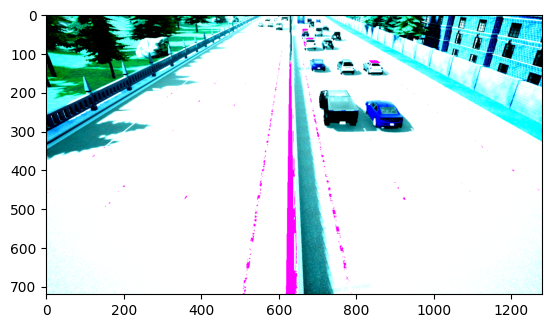

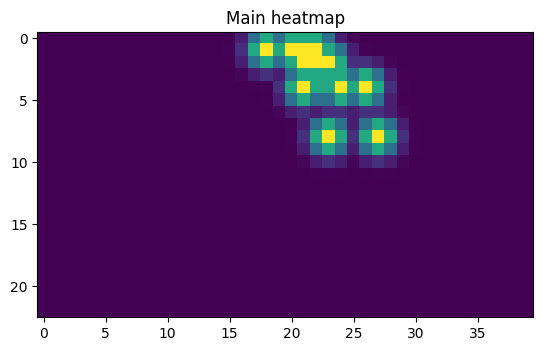

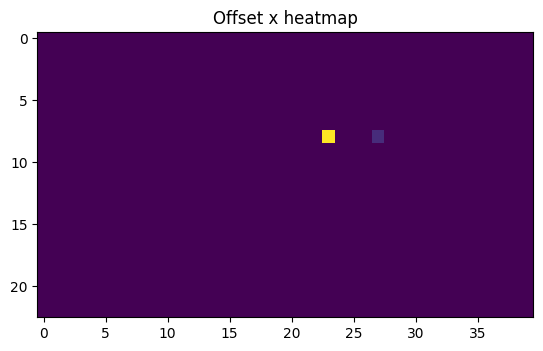

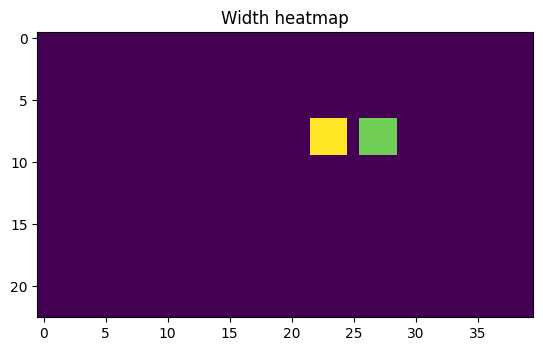

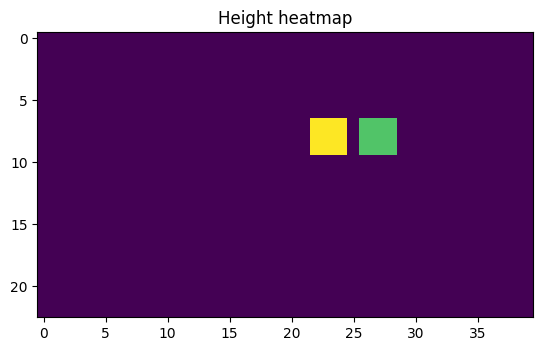

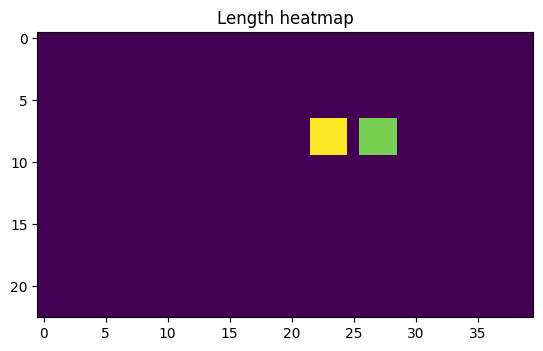

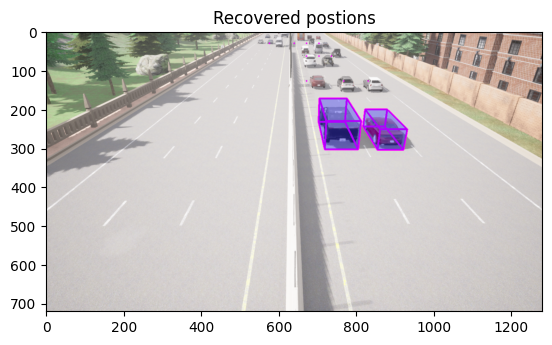

In [28]:
# Check traindataset
k = random.randint(0, len(train_id))
print(k)

# Test dataset
img, hm, offset, regr = traindataset[k]
print(hm.shape)

img = img.transpose([1, 2, 0])
plt.imshow(img)
plt.show()

plt.imshow(hm)
plt.title("Main heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

plt.imshow(regr[1])
plt.title("Height heatmap")
plt.show()

plt.imshow(regr[2])
plt.title("Length heatmap")
plt.show()


# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder, train_id[k]))
img = cv2.resize(img, (input_width, input_height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = showbox(img, hm, offset, regr, 0.99)


boxes, _ = pred2box(hm, offset, regr, thresh=0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [29]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=False)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False)

## Define Centernet model

In [30]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])
        
        num_ch = 512
        
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 1, kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 3, kernel_size=1, stride=1))
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        x = self.base_model(x)
        
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        
        return outc, outo, outr

In [31]:
model = centernet()
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())
print(output[2].size())


torch.Size([1, 1, 23, 40])
torch.Size([1, 2, 23, 40])
torch.Size([1, 3, 23, 40])


In [32]:
summary(model, (1, 3, input_height, input_width))

Layer (type:depth-idx)                        Output Shape              Param #
centernet                                     [1, 1, 23, 40]            --
├─Sequential: 1-1                             [1, 512, 23, 40]          --
│    └─Conv2d: 2-1                            [1, 64, 360, 640]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 360, 640]         128
│    └─ReLU: 2-3                              [1, 64, 360, 640]         --
│    └─MaxPool2d: 2-4                         [1, 64, 180, 320]         --
│    └─Sequential: 2-5                        [1, 64, 180, 320]         --
│    │    └─BasicBlock: 3-1                   [1, 64, 180, 320]         73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 180, 320]         73,984
│    └─Sequential: 2-6                        [1, 128, 90, 160]         --
│    │    └─BasicBlock: 3-3                   [1, 128, 90, 160]         230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 90, 160]         295,42

# Define Loss (Focal loss + L1-loss)

In [33]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, whl_pred, whl_gt, hm_gt):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    mask = hm_gt.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask_2 = mask.expand_as(off_gt).float()
    mask_3 = mask.expand_as(whl_gt).float()
    
    assert off_pred.size() == mask_2.size()
    off_pred = off_pred * mask_2
    off_gt = off_gt * mask_2
    
    whl_pred = whl_pred * mask_3
    whl_gt = whl_gt * mask_3
    assert whl_pred.size() == mask_3.size()
    
    assert mask_3.float().sum() == 3 * num

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    whl_loss = 20.0 * nn.functional.l1_loss(whl_pred, whl_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, whl_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, whl_pred, whl_gt):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred[:, 0])
  
    pred_mask = pred_mask.unsqueeze(1).float()
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, whl_loss = _regr_loss(off_pred, off_gt, whl_pred, whl_gt, hm_gt)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, whl_loss

# Training

In [34]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_whl_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset, regr) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        whl_gt = regr.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_whl = model(img)
        
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, whl_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_whl, whl_gt)
        loss = foc_loss + off_loss + whl_loss
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_whl_loss += float(whl_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (whl={train_whl_loss/(idx+1):.3f})')
    
    scheduler.step()
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_whl_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            whl_gt = regr.to(device)

            # run model
            preds_hm, preds_offset, preds_whl = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, whl_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_whl, whl_gt)
            
            loss = foc_loss + off_loss + whl_loss
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_whl_loss += float(whl_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Whl loss : {train_whl_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Whl loss : {val_whl_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [36]:
model = centernet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

logs = []
best_loss = float('inf')

In [22]:
epochs = 10

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "centernet-3d-bbox.pth")   


epochs 1/15
Learning rate : 5e-05


(l=3.26) (pos=0.824) (neg=0.643) (off=0.261) (whl=1.537): 100%|█| 800/800 [02:16
100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.75it/s]


train loss : 3.2638
Pos loss : 0.8238
Neg loss : 0.6427
Off loss : 0.2607
Whl loss : 1.5366

Val loss : 1.8648
Val Pos loss : 0.4307
Val Neg loss : 0.2057
Val Off loss : 0.1713
Val Whl loss : 1.0571
Improved validation loss to 1.865
epochs 2/15
Learning rate : 5e-05


(l=1.43) (pos=0.254) (neg=0.216) (off=0.163) (whl=0.796): 100%|█| 800/800 [02:23
100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.52it/s]


train loss : 1.4290
Pos loss : 0.2540
Neg loss : 0.2164
Off loss : 0.1627
Whl loss : 0.7959

Val loss : 1.3246
Val Pos loss : 0.2613
Val Neg loss : 0.1380
Val Off loss : 0.1377
Val Whl loss : 0.7875
Improved validation loss to 1.325
epochs 3/15
Learning rate : 5e-05


(l=1.02) (pos=0.142) (neg=0.152) (off=0.125) (whl=0.605): 100%|█| 800/800 [02:23
100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.65it/s]


train loss : 1.0232
Pos loss : 0.1418
Neg loss : 0.1519
Off loss : 0.1250
Whl loss : 0.6046

Val loss : 1.1202
Val Pos loss : 0.2140
Val Neg loss : 0.1013
Val Off loss : 0.1078
Val Whl loss : 0.6972
Improved validation loss to 1.120
epochs 4/15
Learning rate : 5e-05


(l=0.83) (pos=0.089) (neg=0.114) (off=0.102) (whl=0.528): 100%|█| 800/800 [02:24
100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.76it/s]


train loss : 0.8341
Pos loss : 0.0892
Neg loss : 0.1142
Off loss : 0.1025
Whl loss : 0.5283

Val loss : 1.0759
Val Pos loss : 0.1675
Val Neg loss : 0.0954
Val Off loss : 0.0883
Val Whl loss : 0.7247
Improved validation loss to 1.076
epochs 5/15
Learning rate : 5e-05


(l=0.76) (pos=0.070) (neg=0.095) (off=0.092) (whl=0.499): 100%|█| 800/800 [02:23
100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.57it/s]


train loss : 0.7564
Pos loss : 0.0705
Neg loss : 0.0951
Off loss : 0.0918
Whl loss : 0.4990

Val loss : 0.9491
Val Pos loss : 0.1531
Val Neg loss : 0.0766
Val Off loss : 0.0771
Val Whl loss : 0.6422
Improved validation loss to 0.949
epochs 6/15
Learning rate : 5e-06


(l=0.74) (pos=0.064) (neg=0.092) (off=0.082) (whl=0.501): 100%|█| 800/800 [02:24
100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.36it/s]


train loss : 0.7389
Pos loss : 0.0642
Neg loss : 0.0921
Off loss : 0.0816
Whl loss : 0.5009

Val loss : 0.7619
Val Pos loss : 0.1494
Val Neg loss : 0.0898
Val Off loss : 0.0706
Val Whl loss : 0.4521
Improved validation loss to 0.762
epochs 7/15
Learning rate : 5e-06


(l=0.58) (pos=0.051) (neg=0.080) (off=0.071) (whl=0.379): 100%|█| 800/800 [02:25
100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.61it/s]


train loss : 0.5817
Pos loss : 0.0509
Neg loss : 0.0804
Off loss : 0.0710
Whl loss : 0.3794

Val loss : 0.7262
Val Pos loss : 0.1628
Val Neg loss : 0.0753
Val Off loss : 0.0675
Val Whl loss : 0.4206
Improved validation loss to 0.726
epochs 8/15
Learning rate : 5e-06


(l=0.51) (pos=0.045) (neg=0.074) (off=0.066) (whl=0.327): 100%|█| 800/800 [02:25
100%|█████████████████████████████████████████| 200/200 [00:30<00:00,  6.55it/s]


train loss : 0.5113
Pos loss : 0.0446
Neg loss : 0.0738
Off loss : 0.0663
Whl loss : 0.3266

Val loss : 0.7052
Val Pos loss : 0.1683
Val Neg loss : 0.0694
Val Off loss : 0.0631
Val Whl loss : 0.4043
Improved validation loss to 0.705
epochs 9/15
Learning rate : 5e-06


(l=0.46) (pos=0.040) (neg=0.069) (off=0.061) (whl=0.288): 100%|█| 800/800 [02:24
100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.20it/s]


train loss : 0.4581
Pos loss : 0.0403
Neg loss : 0.0686
Off loss : 0.0613
Whl loss : 0.2879

Val loss : 0.6898
Val Pos loss : 0.1808
Val Neg loss : 0.0654
Val Off loss : 0.0612
Val Whl loss : 0.3824
Improved validation loss to 0.690
epochs 10/15
Learning rate : 5e-06


(l=0.42) (pos=0.036) (neg=0.065) (off=0.058) (whl=0.262): 100%|█| 800/800 [02:24
100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.75it/s]


train loss : 0.4209
Pos loss : 0.0362
Neg loss : 0.0647
Off loss : 0.0582
Whl loss : 0.2619

Val loss : 0.6534
Val Pos loss : 0.1691
Val Neg loss : 0.0680
Val Off loss : 0.0563
Val Whl loss : 0.3600
Improved validation loss to 0.653
epochs 11/15
Learning rate : 5.000000000000001e-07


(l=0.42) (pos=0.027) (neg=0.074) (off=0.056) (whl=0.258): 100%|█| 800/800 [02:28
100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.78it/s]


train loss : 0.4164
Pos loss : 0.0274
Neg loss : 0.0743
Off loss : 0.0562
Whl loss : 0.2585

Val loss : 0.6583
Val Pos loss : 0.2336
Val Neg loss : 0.0397
Val Off loss : 0.0512
Val Whl loss : 0.3338
epochs 12/15
Learning rate : 5.000000000000001e-07


(l=0.40) (pos=0.035) (neg=0.064) (off=0.055) (whl=0.248): 100%|█| 800/800 [02:24
100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.70it/s]


train loss : 0.4027
Pos loss : 0.0347
Neg loss : 0.0642
Off loss : 0.0554
Whl loss : 0.2484

Val loss : 0.6574
Val Pos loss : 0.2412
Val Neg loss : 0.0388
Val Off loss : 0.0507
Val Whl loss : 0.3267
epochs 13/15
Learning rate : 5.000000000000001e-07


(l=0.44) (pos=0.030) (neg=0.074) (off=0.069) (whl=0.264):  25%|▎| 202/800 [00:36


KeyboardInterrupt: 

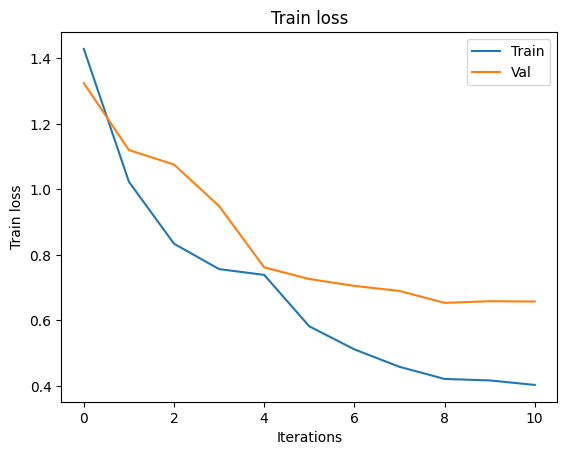

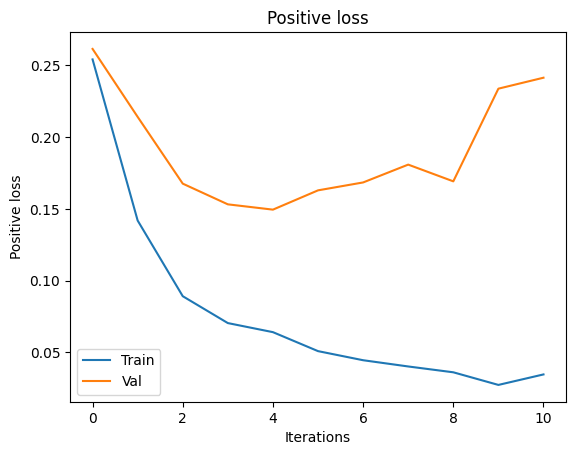

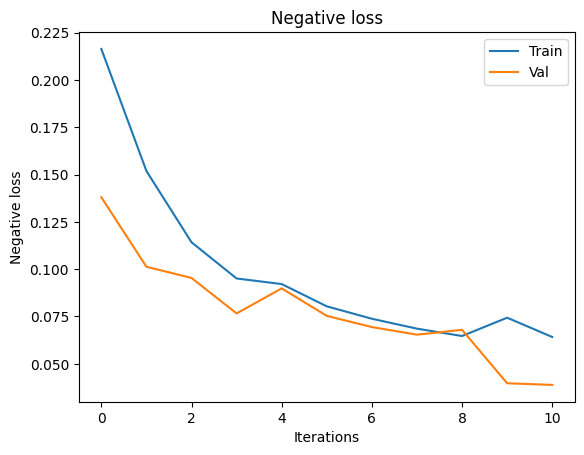

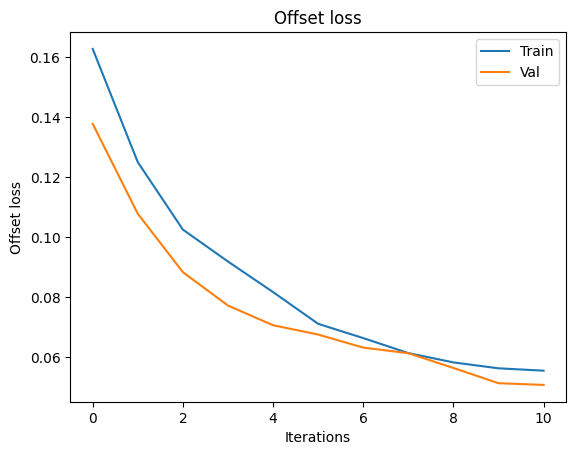

In [23]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

# Show predictions

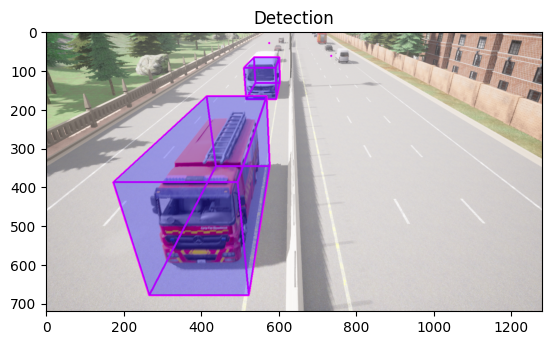

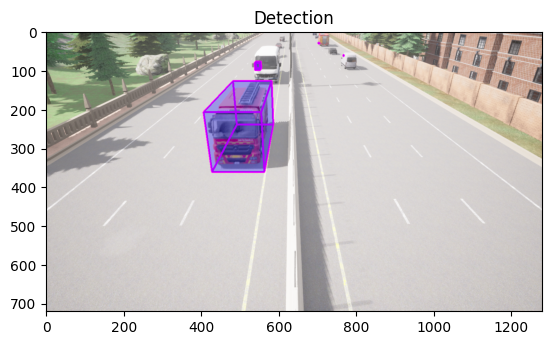

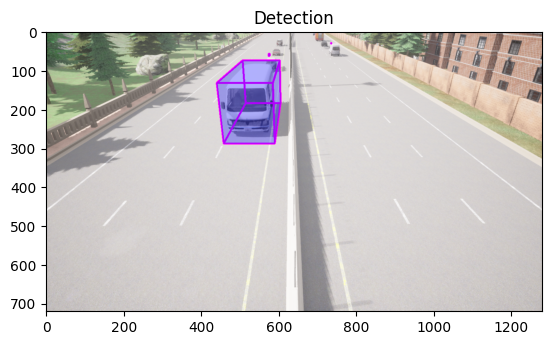

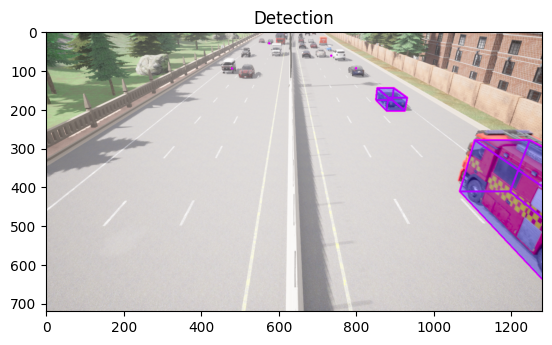

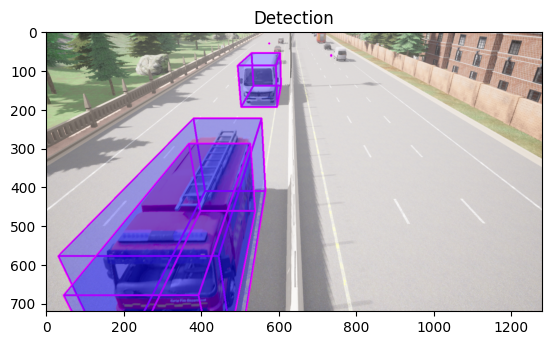

In [39]:
model.load_state_dict(torch.load("centernet-3d-bbox.pth"))
model.eval()

threshold = 0.1

for k in range(5):
    id = random.randint(0, len(test_id))
    
    img, hm_gt, offset_gt, regr_gt = valdataset[id]
    img = torch.from_numpy(img)
    
    with torch.no_grad():
        hm, offset, whl = model(img.to(device).float().unsqueeze(0))

    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    whl = whl.cpu().numpy().squeeze(0)
    
    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder, img_id))
    img = cv2.resize(img, (input_width, input_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    #plt.imshow(hm)
    #plt.show()
    hm = select(hm, threshold)
    
    #plt.imshow(hm>threshold)
    #plt.title(f"Heatmap > {threshold}")
    #plt.show()
    
    #plt.imshow(whl[0])
    #plt.title("Width heatmap (x)")
    #plt.show()
    
    sample = showbox(img, hm, offset, whl, threshold)
    
    boxes, _ = pred2box(hm, offset, whl, thresh=threshold)
    
    #plt.imshow(offset[0])
    #plt.title("Offset heatmap (x)")
    #plt.show()
    
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()